In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta

In [2]:
data = pd.read_csv("MSFT.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060396,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062553,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063632,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062014,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060936,47894400
...,...,...,...,...,...,...,...
9466,2023-10-04,314.029999,320.040009,314.000000,318.959991,318.959991,20720100
9467,2023-10-05,319.089996,319.980011,314.899994,319.359985,319.359985,16965600
9468,2023-10-06,316.549988,329.190002,316.299988,327.260010,327.260010,25645500
9469,2023-10-09,324.750000,330.299988,323.179993,329.820007,329.820007,19891200


In [3]:
data["RSI"]=ta.rsi(data.Close, length=15)
data["EMAF"]=ta.ema(data.Close, length=25)
data["EMAM"]=ta.ema(data.Close, length=100)
data["EMAS"]=ta.ema(data.Close, length=150)

data["TargetNextClose"] = data["Adj Close"].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(["Volume", "Close", "Date", "index"], axis=1, inplace=True)
data

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,TargetNextClose
0,0.115451,0.117188,0.115451,0.072260,66.049344,0.106115,0.104222,0.104508,0.075496
1,0.116319,0.122396,0.116319,0.075496,70.634112,0.107300,0.104564,0.104734,0.075496
2,0.121528,0.122396,0.120660,0.075496,70.634112,0.108395,0.104900,0.104956,0.077653
3,0.121528,0.125868,0.121528,0.077653,73.384280,0.109672,0.105298,0.105221,0.078192
4,0.125000,0.127604,0.122396,0.078192,74.035605,0.110918,0.105705,0.105495,0.081427
...,...,...,...,...,...,...,...,...,...
9316,320.829987,321.390015,311.209991,313.390015,39.934412,322.535459,320.453505,312.601295,318.959991
9317,314.029999,320.040009,314.000000,318.959991,46.069137,322.260423,320.423931,312.685516,319.359985
9318,319.089996,319.980011,314.899994,319.359985,46.489641,322.037312,320.402862,312.773920,327.260010
9319,316.549988,329.190002,316.299988,327.260010,54.068175,322.439058,320.538647,312.965789,329.820007


In [4]:
from sklearn.preprocessing import MinMaxScaler # as using NN feed model with between 1 or 0
sc = MinMaxScaler(feature_range=(0,1))
data_scaled = sc.fit_transform(data)
print(data_scaled)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.40021315e-06 1.42037857e-05 2.46363757e-06 ... 1.06676815e-06
  7.20025344e-07 0.00000000e+00]
 [1.68042573e-05 1.42037857e-05 1.47846637e-05 ... 2.11241217e-06
  1.43051393e-06 6.01413660e-06]
 ...
 [8.82035596e-01 8.72362327e-01 8.93450491e-01 ... 9.97028391e-01
  9.98674149e-01 9.12254224e-01]
 [8.75011909e-01 8.97480748e-01 8.97424083e-01 ... 9.97451064e-01
  9.99286983e-01 9.19391995e-01]
 [8.97686767e-01 9.00508015e-01 9.16951547e-01 ... 9.98023165e-01
  1.00000000e+00 9.15404898e-01]]


In [5]:
X = []

backtest = 5
for j in range(8): # number of rows of inputs
    X.append([])
    for i in range(backtest, data_scaled.shape[0]):#backcandles+2
        X[j].append(data_scaled[i-backtest:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

In [6]:
X, y = np.array(X), np.array(data_scaled[backtest:,-1])
y = np.reshape(y,(len(y),1))
X.shape #9316 rows of 5 days of 8 inputs

(9316, 5, 8)

In [7]:
q_80 = round(int(X.shape[0]) * 0.8)
q_90 = round(int(X.shape[0]) * 0.9)

X_train, y_train = X[:q_80], y[:q_80]
X_val, y_val = X[q_80:q_90], y[q_80:q_90]
X_test, y_test = X[q_90:], y[q_90:]

In [8]:
import tensorflow as tf
import keras
from keras.optimizers import Adam
from keras.callbacks import History
from keras.models import Model
from keras import layers
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint("model4/", save_best_only=True)
model = Sequential([layers.Input((backtest, 8), name="input"),
                    layers.LSTM(150),
                    layers.Dense(1, name = "Dense_layer"),
                    layers.Activation("linear", name = "output")])

model.compile(optimizer=Adam(), loss='mse')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks = [cp])

Epoch 1/20
232/233 [============================>.] - ETA: 0s - loss: 8.5059e-05INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


233/233 [==============================] - 6s 18ms/step - loss: 8.4788e-05 - val_loss: 1.9409e-04
Epoch 2/20
233/233 [==============================] - 1s 5ms/step - loss: 1.3336e-05 - val_loss: 5.7011e-04
Epoch 3/20
233/233 [==============================] - 1s 5ms/step - loss: 5.1251e-06 - val_loss: 2.4122e-04
Epoch 4/20
226/233 [============================>.] - ETA: 0s - loss: 4.7039e-06INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


233/233 [==============================] - 3s 15ms/step - loss: 4.7404e-06 - val_loss: 1.5801e-04
Epoch 5/20
231/233 [============================>.] - ETA: 0s - loss: 4.9225e-06INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


233/233 [==============================] - 4s 18ms/step - loss: 4.9204e-06 - val_loss: 1.3730e-04
Epoch 6/20
222/233 [===========================>..] - ETA: 0s - loss: 4.5268e-06INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


233/233 [==============================] - 4s 15ms/step - loss: 4.5554e-06 - val_loss: 2.9741e-05
Epoch 7/20
231/233 [============================>.] - ETA: 0s - loss: 4.1983e-06INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


233/233 [==============================] - 3s 14ms/step - loss: 4.2228e-06 - val_loss: 2.6446e-05
Epoch 8/20
233/233 [==============================] - 1s 6ms/step - loss: 3.8227e-06 - val_loss: 9.1901e-05
Epoch 9/20
231/233 [============================>.] - ETA: 0s - loss: 4.5125e-06INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


233/233 [==============================] - 3s 14ms/step - loss: 4.5120e-06 - val_loss: 2.2852e-05
Epoch 10/20
233/233 [==============================] - 1s 5ms/step - loss: 3.9906e-06 - val_loss: 4.6836e-05
Epoch 11/20
228/233 [============================>.] - ETA: 0s - loss: 4.7633e-06INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


233/233 [==============================] - 3s 15ms/step - loss: 4.7617e-06 - val_loss: 2.2526e-05
Epoch 12/20
233/233 [==============================] - 1s 5ms/step - loss: 3.5153e-06 - val_loss: 3.3202e-05
Epoch 13/20
233/233 [==============================] - 1s 5ms/step - loss: 4.3139e-06 - val_loss: 5.0555e-05
Epoch 14/20
228/233 [============================>.] - ETA: 0s - loss: 3.3265e-06INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


233/233 [==============================] - 3s 14ms/step - loss: 3.3654e-06 - val_loss: 2.0893e-05
Epoch 15/20
233/233 [==============================] - 1s 5ms/step - loss: 4.0072e-06 - val_loss: 2.8780e-05
Epoch 16/20
233/233 [==============================] - 1s 5ms/step - loss: 4.0161e-06 - val_loss: 2.1693e-05
Epoch 17/20
233/233 [==============================] - 1s 5ms/step - loss: 3.5816e-06 - val_loss: 2.7620e-05
Epoch 18/20
227/233 [============================>.] - ETA: 0s - loss: 3.6222e-06INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


233/233 [==============================] - 3s 14ms/step - loss: 3.6912e-06 - val_loss: 2.0780e-05
Epoch 19/20
233/233 [==============================] - 1s 5ms/step - loss: 3.7998e-06 - val_loss: 2.7336e-05
Epoch 20/20
233/233 [==============================] - 1s 6ms/step - loss: 3.2323e-06 - val_loss: 2.6788e-05


In [9]:
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

30/30 [==============================] - 0s 2ms/step


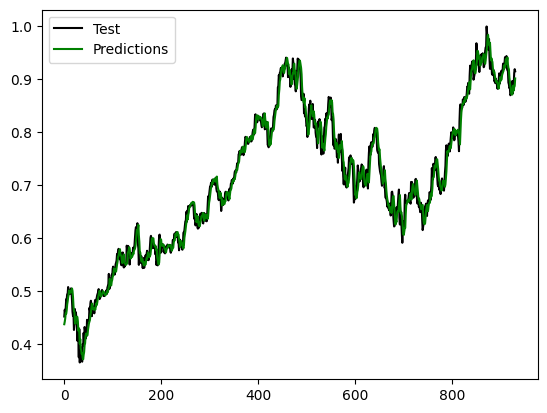

In [10]:
plt.plot(y_test, color = "black", label = "Test")
plt.plot(test_predictions, color = "green", label = "Predictions")
plt.legend()
plt.show()

In [11]:
from keras.models import load_model

filename = "model4"
model = load_model(filename)